cn_data
  chr  bin    cell_id  state  start  end cluster_id      copy
0   1    0  cl1_cell0      2      0    9        cl1  2.943771
1   1    1  cl1_cell0      3     10   19        cl1  3.561983
2   1    2  cl1_cell0      3     20   29        cl1  3.435017
3   1    3  cl1_cell0      3     30   39        cl1  3.055985
4   1    4  cl1_cell0      1     40   49        cl1  1.438367


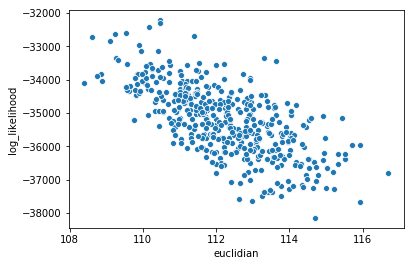

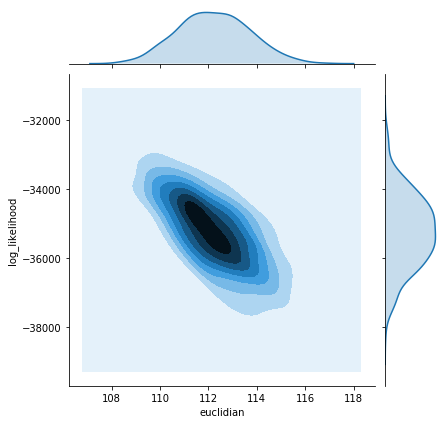

In [19]:
from scgenome import utils
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import numpy as np
from scgenome.jointcnmodels import get_variances, get_tr_probs, calculate_marginal_ll_simple
from scipy import special
import seaborn as sns
import pandas as pd

n_cell = 30
n_bin = 3000

cn_mat = np.concatenate([1+np.random.poisson(lam=2, size=n_bin)[np.newaxis,:] for i in range(n_cell)])
n_states = cn_mat.max()
cell_ids = [f"cl1_cell{i}" for i in range(n_cell)]
chr_names = ["1", "2"]
df_cn_mat = utils.cn_mat_as_df(cn_mat, chr_names)
#print(f"df_cn_mat \n {df_cn_mat}")

cn_data = utils.cn_mat_to_cn_data(df_cn_mat, cell_id_vals=cell_ids)
cn_data["cluster_id"] = cn_data["cell_id"].str.split("_", expand=True).iloc[:, 0]
cn_data["state"] = cn_data["copy"] + abs(np.random.normal(scale=0.5,size=cn_data.shape[0]))
cn_data.columns = ["chr","bin","cell_id","state","start","end","cluster_id","copy"]

matrix_data, measurement, cell_ids = utils.cn_data_to_mat_data_ids(cn_data, value_ids=["copy"])
#matrix_data2 = (
#    cn_data
#        .merge(pd.DataFrame({'cell_id': cell_ids}))
#        .set_index(['chr', 'start', 'cell_id'])[['state', 'copy']]
#        .unstack(level=2, fill_value=0.))

print("cn_data")
print(cn_data.head())
old_variances = get_variances(cn_data, matrix_data, n_states)
cell_state_var = cn_data[['cell_id', 'state', 'copy']].dropna() \
                    .groupby(['cell_id', 'state'])['copy'] \
                    .var().rename('copy_var') \
                    .reset_index()
#print("cell_state_var")
#print(cell_state_var)
    
variances = cell_state_var.set_index(["state",'cell_id'])['copy_var'].unstack()
#print(variances.head())
#print(variances.shape)
variances = variances.reindex(columns=cell_ids, index=range(n_states)).fillna(0.05).T
variances = variances.values

variances[variances < 0.001] = 0.001

#variances = get_variances(cn_data, matrix_data, n_state)

trans_model = {"kind":"twoparam", "e0": 0.9, "e1": 0.1}

pw_euc = squareform(pdist(measurement))

pw_ll = np.zeros((n_cell, n_cell))
for i,j in combinations(range(n_cell), 2):
    pw_ll[i, j] = calculate_marginal_ll_simple(measurement[[i,j], :], old_variances[[i,j], :], trans_model)
    
#print(f"pw_euc \n{pw_euc}")
#print(f"pw_ll \n{pw_ll}")
#print(f"cn_mat \n{cn_mat}")
#print(f"cn_data \n{cn_data}")

pwd = pd.DataFrame({"euclidian" : pw_euc[np.triu_indices(n_cell,1)],
                    "log_likelihood" : pw_ll[np.triu_indices(n_cell,1)]})
sns.scatterplot(data=pwd, x="euclidian", y="log_likelihood")
sns.jointplot(data=pwd, x="euclidian", y="log_likelihood", kind="kde")

In [14]:
cn_data["reads"] = 1
display(cn_data.head())

def conv(cn_data, index_ids = ["chr","start","cell_id"], value_ids=["reads","state","copy"]):
    matrix_data = (
        cn_data.set_index(index_ids)[value_ids]
            .unstack(level=2, fill_value=0.))
    copy = matrix_data["copy"].values
    measurement = copy.T

    cell_ids = matrix_data["copy"].columns
    return matrix_data, measurement, cell_ids

def cn_data_to_mat_data_ids(cn_data, data_id=CN_DATA_ID, cell_id=CELL_ID,
                            index_ids=INDEX_IDS, value_ids=VALUE_IDS):
    matrix_data = (
        cn_data.set_index(index_ids)[value_ids]
            .unstack(level=2, fill_value=0.))
    copy = matrix_data[data_id].values
    measurement = copy.T

    cell_ids = matrix_data.columns.to_frame().loc[data_id][cell_id]
    return matrix_data, measurement, cell_ids

res = conv(cn_data)
display(res[0])
display(res[1])
display(res[1].shape)
display(cn_mat)
display(res[2])
display(res[2].shape)

,chr,bin,cell_id,state,start,end,cluster_id,copy,reads
0,1,0,cl1_cell0,2,0,9,cl1,2.384862,1
1,1,1,cl1_cell0,3,10,19,cl1,3.213635,1
2,1,2,cl1_cell0,4,20,29,cl1,4.715666,1
3,1,3,cl1_cell0,2,30,39,cl1,2.115816,1
4,1,4,cl1_cell0,4,40,49,cl1,4.064646,1


reads                                                        \
cell_id   cl1_cell0 cl1_cell1 cl1_cell10 cl1_cell11 cl1_cell12 cl1_cell13   
chr start                                                                   
1   0             1         1          1          1          1          1   
    10            1         1          1          1          1          1   
    20            1         1          1          1          1          1   
    30            1         1          1          1          1          1   
    40            1         1          1          1          1          1   
    50            1         1          1          1          1          1   
    60            1         1          1          1          1          1   
    70            1         1          1          1          1          1   
    80            1         1          1          1          1          1   
    90            1         1          1          1          1          1   
    100           1         1          1          1          1          1   
    110           1         1          1          1          1          1   
    120           1         1          1          1          1          1   
    130           1         1          1          1          1          1   
    140           1         1          1          1          1          1   
    150           1         1          1          1          1          1   
    160           1         1          1          1          1          1   
    170           1         1          1          1          1          1   
    180           1         1          1          1          1          1   
    190           1         1          1          1          1          1   
    200           1         1          1          1          1          1   
    210           1         1          1          1          1          1   
    220           1         1          1          1          1          1   
    230           1         1          1          1          1          1   
    240           1         1          1          1          1          1   
    250           1         1          1          1          1          1   
    260           1         1          1          1          1          1   
    270           1         1          1          1          1          1   
    280           1         1          1          1          1          1   
    290           1         1          1          1          1          1   
...             ...       ...        ...        ...        ...        ...   
2   29700         1         1          1          1          1          1   
    29710         1         1          1          1          1          1   
    29720         1         1          1          1          1          1   
    29730         1         1          1          1          1          1   
    29740         1         1          1          1          1          1   
    29750         1         1          1          1          1          1   
    29760         1         1          1          1          1          1   
    29770         1         1          1          1          1          1   
    29780         1         1          1          1          1          1   
    29790         1         1          1          1          1          1   
    29800         1         1          1          1          1          1   
    29810         1         1          1          1          1          1   
    29820         1         1          1          1          1          1   
    29830         1         1          1          1          1          1   
    29840         1         1          1          1          1          1   
    29850         1         1          1          1          1          1   
    29860         1         1          1          1          1          1   
    29870         1         1          1          1          1          1   
    29880 

array([[2.38486204, 3.2136347 , 4.71566585, ..., 4.25213228, 3.37546152,
        3.3619273 ],
       [1.09308696, 7.84230184, 2.57316445, ..., 2.61318993, 4.89600777,
        3.23400525],
       [3.12443011, 6.23071342, 4.06220525, ..., 2.53490068, 1.28128525,
        3.02896531],
       ...,
       [2.03662685, 2.00202804, 3.20728217, ..., 2.4363144 , 2.63314016,
        5.54094802],
       [2.23690523, 5.12320685, 1.66403486, ..., 3.08132883, 4.48736636,
        2.42344298],
       [4.14832439, 2.22910757, 4.49177588, ..., 4.85064988, 2.25918527,
        2.18313797]])

(30, 3000)

array([[2, 3, 4, ..., 4, 3, 3],
       [1, 7, 2, ..., 2, 4, 3],
       [4, 2, 3, ..., 4, 4, 3],
       ...,
       [3, 3, 3, ..., 1, 3, 3],
       [2, 3, 1, ..., 1, 5, 1],
       [3, 2, 4, ..., 4, 1, 5]])

Index(['cl1_cell0', 'cl1_cell1', 'cl1_cell10', 'cl1_cell11', 'cl1_cell12',
       'cl1_cell13', 'cl1_cell14', 'cl1_cell15', 'cl1_cell16', 'cl1_cell17',
       'cl1_cell18', 'cl1_cell19', 'cl1_cell2', 'cl1_cell20', 'cl1_cell21',
       'cl1_cell22', 'cl1_cell23', 'cl1_cell24', 'cl1_cell25', 'cl1_cell26',
       'cl1_cell27', 'cl1_cell28', 'cl1_cell29', 'cl1_cell3', 'cl1_cell4',
       'cl1_cell5', 'cl1_cell6', 'cl1_cell7', 'cl1_cell8', 'cl1_cell9'],
      dtype='object', name='cell_id')

(30,)

In [20]:
old_variances == variances

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  Tr

In [12]:
pw_euc

array([[ 0.        , 30.98804289, 31.82838566, ..., 32.03855084,
        32.40225677, 32.90686509],
       [30.98804289,  0.        , 31.56414923, ..., 31.2849748 ,
        30.41000579, 31.282114  ],
       [31.82838566, 31.56414923,  0.        , ..., 31.31081775,
        30.54465633, 33.10146208],
       ...,
       [32.03855084, 31.2849748 , 31.31081775, ...,  0.        ,
        32.18035399, 32.74232728],
       [32.40225677, 30.41000579, 30.54465633, ..., 32.18035399,
         0.        , 31.68167703],
       [32.90686509, 31.282114  , 33.10146208, ..., 32.74232728,
        31.68167703,  0.        ]])